In [1]:
# import modules
import uproot, sys, time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import awkward as ak
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker

# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 14.0,10.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 20.0 # Use 14 point font
sns.set(style="whitegrid")

font_size = {
    "xlabel": 17,
    "ylabel": 17,
    "xticks": 15,
    "yticks": 15,
    "legend": 18
}

plt.rcParams.update({
    "axes.labelsize": font_size["xlabel"],  # X and Y axis labels
    "xtick.labelsize": font_size["xticks"],  # X ticks
    "ytick.labelsize": font_size["yticks"],  # Y ticks
    "legend.fontsize": font_size["legend"]  # Legend
})

In [2]:
def getWeight(fb, sample):
    # lumi = 25767.5
    lumi = 135000
    weight = fb['mconly_weight']/fb['mc_weight_sum']*fb['xsec_ami']*fb['filter_eff_ami']*fb['kfactor_ami']*fb['pu_weight']*fb['jvt_weight']*1000*lumi
    if sample in ['ggHyyd','WH','VBF','ZH'] : 
        xsec_sig = 0.052 #if ( period == 'Run3' or 'mc23' in period ) else 0.048
        # if sample != 'ggHyyd' : xsec_sig = fb['xsec_ami']
        br = 0.01
        weight = fb['mconly_weight']/fb['mc_weight_sum']*xsec_sig*fb['pu_weight']*fb['jvt_weight']*fb['filter_eff_ami']*fb['kfactor_ami']*1000*lumi*br
    return weight

def getSampleDict():
    sample_dict = {}
    sample_dict['Zjets'] = {
        'color': 'darkgreen',   # approximates ROOT.kGreen-2
        'legend': r'Z($\nu\nu$, ll)+jets',
        'tree': 'nominal',
        'filenames': ['Zjets']
    }
    sample_dict['Zgamma'] = {
        'color': '#e6550d',      # approximates ROOT.kOrange+7
        'legend': r'Z($\nu\nu$)+$\gamma$',
        'tree': 'nominal',
        'filenames': ['Zgamma']
    }
    sample_dict['Wgamma'] = {
        'color': 'darkorange',  # approximates ROOT.kOrange+1
        'legend': r'W($l\nu$)+$\gamma$',
        'tree': 'nominal',
        'filenames': ['Wgamma']
    }
    sample_dict['Wjets'] = {
        'color': 'teal',        # approximates ROOT.kTeal+5
        'legend': r'W($l\nu$)+jets',
        'tree': 'nominal',
        'filenames': ['Wjets']
    }
    sample_dict['gammajet_direct'] = {
        'color': 'royalblue',   # approximates ROOT.kBlue+2
        'legend': r'$\gamma$+jets direct',
        'tree': 'gammajets',
        'filenames': ['gammajet_direct']
    }
    sample_dict['gammajet_frag'] = {
        'color': 'navy',        # approximates ROOT.kBlue-5
        'legend': r'$\gamma$+jets frag',
        'tree': 'gammajets',
        'filenames': ['gammajet_frag']
    }
    sample_dict['dijet'] = {
        'color': 'cyan',        # approximates ROOT.kCyan+1
        'legend': 'multijets',
        'tree': 'dijets',
        'filenames': ['dijet']
    }
    sample_dict['ggHyyd'] = {
        'color': 'red',         # approximates ROOT.kRed
        'legend': r'ggH, H$\rightarrow\gamma\gamma_{d}$',
        'tree': 'nominal',
        'filenames': ['ggHyyd']
    }
    return sample_dict
sample_dict = getSampleDict()

def getVarDict(fb, process, var_name=None):
    var_dict = {}

    # this has the same size as weight, so don't need adjustment on weighting
    if var_name is None or var_name == 'vtx_sumPt':
        var_dict['vtx_sumPt'] = {
            'var': ak.flatten(fb['vtx_sumPt']),
            'bins': np.linspace(0, 100, 20+1),  # 21 edges for 20 bins
            'title': r'vtx\_sumPt'
        }

    if var_name is None or var_name == 'n_ph':
        var_dict['n_ph'] = {
            'var': fb['n_ph'],
            'bins': np.linspace(0, 7, 7+1),
            'title': r'$N_{ph}$'
        }

    if var_name is None or var_name == 'n_ph_baseline':
        var_dict['n_ph_baseline'] = {
            'var': fb['n_ph_baseline'],
            'bins': np.linspace(0, 7, 7+1),
            'title': r'$N_{ph\_baseline}$'
        }

    if var_name is None or var_name == 'n_el_baseline':
        var_dict['n_el_baseline'] = {
            'var': fb['n_el_baseline'],
            'bins': np.linspace(0, 7, 7+1),
            'title': r'$N_{el\_baseline}$'
        }

    if var_name is None or var_name == 'n_mu_baseline':
        var_dict['n_mu_baseline'] = {
            'var': fb['n_mu_baseline'],
            'bins': np.linspace(0, 7, 7+1),
            'title': r'$N_{mu\_baseline}$'
        }

    if var_name is None or var_name == 'n_tau_baseline':
        var_dict['n_tau_baseline'] = {
            'var': fb['n_tau_baseline'],
            'bins': np.linspace(0, 7, 7+1),
            'title': r'$N_{tau\_baseline}$'
        }

    if var_name is None or var_name == 'puWeight':
        var_dict['puWeight'] = {
            'var': fb['pu_weight'],
            'bins': np.linspace(0, 2, 50+1),
            'title': r'PU weight',
            'shift': '+0'
        }

    if var_name is None or var_name == 'actualIntPerXing':
        var_dict['actualIntPerXing'] = {
            'var': fb['actualIntPerXing'],
            'bins': np.linspace(0, 100, 50+1),
            'title': r'$\langle\mu\rangle$',
            'shift': '+0'
        }

    if var_name is None or var_name == 'mt':
        var_dict['mt'] = {
            'var': np.sqrt(2 * fb['met_tst_et'] * ak.firsts(fb['ph_pt']) * 
                           (1 - np.cos(fb['met_tst_phi'] - ak.firsts(fb['ph_phi'])))) / 1000,
            'bins': np.linspace(0, 300, 15+1),
            'title': r'$m_T\ [GeV]$',
            'shift': '+0'
        }

    if var_name is None or var_name == 'metsig':
        var_dict['metsig'] = {
            'var': fb['met_tst_sig'],
            'bins': np.linspace(0, 30, 15+1),
            'title': r'$E_T^{miss}\ significance$',
            'shift': '*1'
        }

    if var_name is None or var_name == 'metsigres':
        var_dict['metsigres'] = {
            'var': fb['met_tst_et'] / fb['met_tst_sig'],
            'bins': np.linspace(0, 100000, 50+1),
            'title': r'$E_T^{miss}\ significance$',
            'shift': '*1'
        }

    if var_name is None or var_name == 'met':
        var_dict['met'] = {
            'var': fb['met_tst_et'],
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$E_T^{miss}\ [MeV]$',
            'shift': '+50000'
        }

    if var_name is None or var_name == 'met_noJVT':
        var_dict['met_noJVT'] = {
            'var': fb['met_tst_noJVT_et'],
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$E_T^{miss}\ [MeV]$'
        }

    if var_name is None or var_name == 'met_cst':
        var_dict['met_cst'] = {
            'var': fb['met_cst_et'],
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$E_T^{miss}\ CST\ [MeV]$'
        }

    if var_name is None or var_name == 'met_track':
        var_dict['met_track'] = {
            'var': fb['met_track_et'],
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$E_T^{miss}\ Track\ [MeV]$'
        }

    if var_name is None or var_name == 'dmet':
        var_dict['dmet'] = {
            'var': fb['met_tst_noJVT_et'] - fb['met_tst_et'],
            'bins': np.linspace(-100000, 100000, 20+1),
            'title': r'$E_{T,\mathrm{noJVT}}^{miss}-E_T^{miss}\ [MeV]$',
            'shift': '*1'
        }

    if var_name is None or var_name == 'ph_pt':
        var_dict['ph_pt'] = {
            'var': ak.firsts(fb['ph_pt']),
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$p_T^{\gamma}\ [MeV]$',
            'shift': '-150000'
        }

    if var_name is None or var_name == 'ph_eta':
        var_dict['ph_eta'] = {
            'var': np.abs(ak.firsts(fb['ph_eta'])),
            'bins': np.linspace(0, 4, 16+1),
            'title': r'$\eta^{\gamma}$'
        }

    if var_name is None or var_name == 'ph_phi':
        var_dict['ph_phi'] = {
            'var': ak.firsts(fb['ph_phi']),
            'bins': np.linspace(-4, 4, 50+1),
            'title': r'$\phi^{\gamma}$'
        }

    if var_name is None or var_name == "jet_central_eta":
        jet_central_eta_tmp = ak.firsts(fb['jet_central_eta'])
        var_dict['jet_central_eta'] = {
            'var': ak.fill_none(jet_central_eta_tmp, -999),
            'bins': np.linspace(-4, 4, 50+1), 
            'title': r'$\eta^{\mathrm{jets}}$'
        }

    # Jet central pt1 (first jet)
    if var_name is None or var_name == "jet_central_pt1":
        jet_central_pt1_tmp = ak.firsts(fb['jet_central_pt'])
        var_dict['jet_central_pt1'] = {
            'var': ak.fill_none(jet_central_pt1_tmp, -999),
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$p_T^{j1}\ [MeV]$'
        }

    # Jet central pt2 (second jet, if available)
    if var_name is None or var_name == "jet_central_pt2":
        jet_central_pt2_tmp = ak.mask(fb['jet_central_pt'], ak.num(fb['jet_central_pt']) >= 2)[:, 1]
        var_dict['jet_central_pt2'] = {
            'var': ak.fill_none(jet_central_pt2_tmp, -999),
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$p_T^{j2}\ [MeV]$'
        }

    # Jet central pt (all jets)
    if var_name is None or var_name == "jet_central_pt":
        weight_tmp = getWeight(fb, process)
        expanded_weights = ak.flatten(ak.broadcast_arrays(weight_tmp, fb['jet_central_pt'])[0])
        var_dict['jet_central_pt'] = {
            'var': ak.flatten(fb['jet_central_pt']),
            'weight': expanded_weights,
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$p_T^{j}\ [MeV]$'
    }

    if var_name is None or var_name == 'dphi_met_phterm':
        var_dict['dphi_met_phterm'] = {
            'var': np.arccos(np.cos(fb['met_tst_phi'] - fb['met_phterm_phi'])),
            'bins': np.linspace(0, 4, 16+1),
            'title': r'$\Delta\phi(E_T^{miss},\, E_T^{\gamma})$',
            'shift': '+0'
        }

    if var_name is None or var_name == 'dphi_met_ph':
        var_dict['dphi_met_ph'] = {
            'var': np.arccos(np.cos(fb['met_tst_phi'] - ak.firsts(fb['ph_phi']))),
            'bins': np.linspace(0, 4, 50+1),
            'title': r'$\Delta\phi(E_T^{miss},\, E_T^{\gamma})$'
        }

    if var_name is None or var_name == 'dphi_met_jetterm':
        var_dict['dphi_met_jetterm'] = {
            'var': np.where(fb['met_jetterm_et'] != 0,
                            np.arccos(np.cos(fb['met_tst_phi'] - fb['met_jetterm_phi'])),
                            -999),
            'bins': np.linspace(0, 4, 16+1),
            'title': r'$\Delta\phi(E_T^{miss},\, E_T^{jet})$'
        }

    if var_name is None or var_name == 'dphi_phterm_jetterm':
        var_dict['dphi_phterm_jetterm'] = {
            'var': np.where(fb['met_jetterm_et'] > 0,
                            np.arccos(np.cos(fb['met_phterm_phi'] - fb['met_jetterm_phi'])),
                            -999),
            'bins': np.linspace(0, 4, 50+1),
            'title': r'$\Delta\phi(E_T^{\gamma},\, E_T^{jet})$'
        }

    if var_name is None or var_name == 'dphi_met_phterm_minus_dphi_met_jetterm':
        var_dict['dphi_met_phterm_minus_dphi_met_jetterm'] = {
            'var': np.where(fb['met_jetterm_et'] > 0,
                            np.arccos(np.cos(fb['met_tst_phi'] - fb['met_phterm_phi'])) -
                            np.arccos(np.cos(fb['met_tst_phi'] - fb['met_jetterm_phi'])),
                            -999),  
            'bins': np.linspace(-4, 4, 100+1),
            'title': r'$\Delta\phi(E_T^{miss},\, E_T^{\gamma})-\Delta\phi(E_T^{miss},\, E_T^{jet})$'
        }

    if var_name is None or var_name == 'dphi_met_phterm_divide_dphi_met_jetterm':
        numerator_tmp = np.arccos(np.cos(fb['met_tst_phi'] - fb['met_phterm_phi']))
        denominator_tmp = np.arccos(np.cos(fb['met_tst_phi'] - fb['met_jetterm_phi']))
        var_dict['dphi_met_phterm_divide_dphi_met_jetterm'] = {
            'var': np.where((fb['met_jetterm_et'] > 0) & (denominator_tmp != 0),
                            numerator_tmp / denominator_tmp,
                            -999),  
            'bins': np.linspace(0, 200, 100+1),
            'title': r'$\Delta\phi(E_T^{miss},\, E_T^{\gamma})/\Delta\phi(E_T^{miss},\, E_T^{jet})$'
        }


    # Delta phi (photon vs. central jet1)
    if var_name is None or var_name == 'dphi_ph_centraljet1':
        dphi_ph_centraljet1_tmp = np.arccos(np.cos(ak.firsts(fb['ph_phi']) - ak.firsts(fb['jet_central_phi'])))
        var_dict['dphi_ph_centraljet1'] = {
            'var': ak.fill_none(dphi_ph_centraljet1_tmp, -999),
            'bins': np.linspace(0, 4, 50+1),
            'title': r'$\Delta\phi(\gamma,\, j1)$'
        }

    # # Delta phi (photon vs. jet1)
    if var_name is None or var_name == 'dphi_ph_jet1':
        dphi_ph_jet1_tmp = np.arccos(np.cos(ak.firsts(fb['ph_phi']) - ak.firsts(fb['jet_central_phi'])))
        var_dict['dphi_ph_jet1'] = {
            'var': ak.fill_none(dphi_ph_jet1_tmp, -999),
            'bins': np.linspace(0, 4, 50+1),
            'title': r'$\Delta\phi(\gamma,\, j1)$'
        }

    # # Delta phi (central jet1 vs. jet2) (repeated with dphi_jj)
    # if var_name is None or var_name == 'dphi_central_jet1_jet2':
    #     phi1_tmp = ak.firsts(fb['jet_central_phi'])
    #     phi2_tmp = ak.mask(fb['jet_central_phi'], ak.num(fb['jet_central_phi']) >= 2)[:, 1]
    #     dphi_central_tmp = np.arccos(np.cos(phi1_tmp - phi2_tmp))
    #     var_dict['dphi_central_jet1_jet2'] = {
    #         'var': ak.fill_none(dphi_central_tmp, -999),
    #         'bins': np.linspace(0, 4, 50+1),
    #         'title': r'$\Delta\phi(j1,\, j2)$'
    #     }

    # Met plus photon pt
    if var_name is None or var_name == 'metplusph':
        var_dict['metplusph'] = {
            'var': fb['met_tst_et'] + ak.firsts(fb['ph_pt']),
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$E_T^{miss}+p_T^{\gamma}\ [MeV]$'
        }

    # # Fail JVT jet pt (all)
    if var_name is None or var_name == 'failJVT_jet_pt':
        weight_tmp = getWeight(fb, process)
        expanded_weights = ak.flatten(ak.broadcast_arrays(weight_tmp, fb['failJVT_jet_pt'])[0])
        var_dict['failJVT_jet_pt'] = {
            'var': ak.flatten(fb['failJVT_jet_pt']),
            'weight': expanded_weights,
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$p_T^{\mathrm{noJVT\ jet}}\ [MeV]$'
        }

    # # Fail JVT jet pt1 (first element)
    if var_name is None or var_name == 'failJVT_jet_pt1':
        failJVT_jet_pt_tmp = ak.firsts(fb['failJVT_jet_pt'])
        var_dict['failJVT_jet_pt1'] = {
            'var': ak.fill_none(failJVT_jet_pt_tmp, -999),
            'bins': np.linspace(20000, 60000, 40+1),
            'title': r'$p_T^{\mathrm{noJVT\ jet1}}\ [MeV]$'
        }

    if var_name is None or var_name == 'softerm':
        var_dict['softerm'] = {
            'var': fb['met_softerm_tst_et'],
            'bins': np.linspace(0, 100000, 50+1),
            'title': r'$E_T^{soft}\ [MeV]$'
        }

    if var_name is None or var_name == 'jetterm':
        var_dict['jetterm'] = {
            'var': fb['met_jetterm_et'],
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$E_T^{jet}\ [MeV]$'
        }

    if var_name is None or var_name == 'jetterm_sumet':
        var_dict['jetterm_sumet'] = {
            'var': fb['met_jetterm_sumet'],
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$E_T^{jet}\ [MeV]$'
        }

    if var_name is None or var_name == 'n_jet':
        var_dict['n_jet'] = {
            'var': fb['n_jet'],
            'bins': np.linspace(0, 10, 10+1),
            'title': r'$N_{jet}$'
        }

    if var_name is None or var_name == 'n_jet_central':
        var_dict['n_jet_central'] = {
            'var': fb['n_jet_central'],
            'bins': np.linspace(0, 10, 10+1),
            'title': r'$N_{jet}^{central}$'
        }

    if var_name is None or var_name == 'n_jet_fwd':
        var_dict['n_jet_fwd'] = {
            'var': fb['n_jet'] - fb['n_jet_central'],
            'bins': np.linspace(0, 10, 10+1),
            'title': r'$N_{jet}^{fwd}$'
        }

    # if var_name is None or var_name == 'vertex':
    #     var_dict['vertex'] = {
    #         'var': (np.abs(ak.firsts(fb['pv_truth_z']) - ak.firsts(fb['pv_z'])) == 
    #                 np.min(np.abs(ak.firsts(fb['pv_truth_z']) - fb['pv_z']))),
    #         'bins': np.linspace(0, 2, 2+1),
    #         'title': r'good PV'
    #     }

    if var_name is None or var_name == 'goodPV':
        var_dict['goodPV'] = {
            'var': (np.abs(ak.firsts(fb['pv_truth_z']) - ak.firsts(fb['pv_z'])) <= 0.5),
            'bins': np.linspace(0, 2, 2+1),
            'title': r'good PV'
        }
    # # Delta phi (met vs. central jet)
    if var_name is None or var_name == 'dphi_met_central_jet':
        dphi_met_central_jet_tmp = np.arccos(np.cos(fb['met_tst_phi'] - ak.firsts(fb['jet_central_phi'])))
        var_dict['dphi_met_central_jet'] = {
            'var': ak.fill_none(dphi_met_central_jet_tmp, -999),
            'bins': np.linspace(0, 4, 50+1),
            'title': r'$\Delta\phi(E_T^{miss},\, jet)$'
        }

    # # Counts: constant 0.5 (typically used for normalization)
    # var_dict['counts'] = {
    #     'var': 0.5,
    #     'bins': np.linspace(0, 1, 1+1),
    #     'title': ''
    # }

    # # Jet central timing1
    if var_name is None or var_name == 'jet_central_timing1':
        jet_central_timing1_tmp = ak.firsts(fb['jet_central_timing'])
        var_dict['jet_central_timing1'] = {
            'var': ak.fill_none(jet_central_timing1_tmp, -999),
            'bins': np.linspace(-40, 40, 50+1),
            'title': r'$Jet\ timing$'
        }

    # # Jet central timing (all)
    if var_name is None or var_name == 'jet_central_timing':
        weight_tmp = getWeight(fb, process)
        expanded_weights = ak.flatten(ak.broadcast_arrays(weight_tmp, fb['jet_central_timing'])[0])
        var_dict['jet_central_timing'] = {
            'var': ak.flatten(fb['jet_central_timing']),
            'weight': expanded_weights,
            'bins': np.linspace(-40, 40, 50+1),
            'title': r'$Jet\ timing$'
        }

    # # Jet central EM fraction
    if var_name is None or var_name == 'jet_central_emfrac':
        weight_tmp = getWeight(fb, process)
        expanded_weights = ak.flatten(ak.broadcast_arrays(weight_tmp, fb['jet_central_emfrac'])[0])
        var_dict['jet_central_emfrac'] = {
            'var': ak.flatten(fb['jet_central_emfrac']),
            'bins': np.linspace(-1, 2, 50+1),
            'title': r'$Jet\ EM\ fraction$'
        }

    if var_name is None or var_name == 'jet_central_emfrac':
        jet_central_emfrac1_tmp = ak.firsts(fb['jet_central_emfrac'])
        var_dict['jet_central_emfrac'] = {
            'var': ak.fill_none(jet_central_emfrac1_tmp, -999),
            'bins': np.linspace(-1, 2, 50+1),
            'title': r'$Jet\ EM\ fraction$'
        }


    # Balance: (met_tst_et+ph_pt[0]) divided by the sum over jet_central_pt.
    if var_name is None or var_name == 'balance':
        jet_sum_tmp = ak.sum(fb['jet_central_pt'], axis=-1)
        expr = (fb['met_tst_et'] + ak.firsts(fb['ph_pt'])) / ak.where(jet_sum_tmp != 0, jet_sum_tmp, 1)
        balance = ak.where(jet_sum_tmp != 0, expr, -999) 

        var_dict['balance'] = {
            'var': balance,
            'bins': np.linspace(0, 20, 100+1),
            'title': r'balance'
        }

    if var_name is None or var_name == 'balance_sumet':
        sumet_tmp = fb['met_jetterm_sumet']
        expr = (fb['met_tst_et'] + ak.firsts(fb['ph_pt'])) / ak.where(sumet_tmp != 0, sumet_tmp, 1)
        balance_sumet = ak.where(sumet_tmp != 0, expr, -999)

        var_dict['balance_sumet'] = {
            'var': balance_sumet,
            'bins': np.linspace(0, 80, 80+1),
            'title': r'balance'
        }

    if var_name is None or var_name == 'central_jets_fraction':
        var_dict['central_jets_fraction'] = {
            'var': np.where(fb['n_jet'] > 0, fb['n_jet_central']/fb['n_jet'], -1),
            'bins': np.linspace(-1, 2, 50+1),
            'title': r'Central jets fraction'
        }

    if var_name is None or var_name == 'trigger':
        var_dict['trigger'] = {
            'var': fb['trigger_HLT_g50_tight_xe40_cell_xe70_pfopufit_80mTAC_L1eEM26M'],
            'bins': np.linspace(0, 2, 2+1),
            'title': r'Pass Trigger'
        }

    # dphi_jj: Use Alt$ logic – if jet_central_phi has at least two entries, compute the difference; else -1.
    # Here we use a Python conditional (this assumes fb['jet_central_phi'] is an array with shape information).
    if var_name is None or var_name == 'dphi_jj':
        phi1_tmp = ak.firsts(fb['jet_central_phi'])
        phi2_tmp = ak.mask(fb['jet_central_phi'], ak.num(fb['jet_central_phi']) >= 2)[:, 1]
        dphi_tmp = np.arccos(np.cos(phi1_tmp - phi2_tmp))
        var_dict['dphi_jj'] = {
            'var': ak.fill_none(dphi_tmp, -999),
            'bins': np.linspace(-1, 4, 20+1),
            'title': r'$\Delta\phi(j1,\, j2)$'
        }
    
    if var_name is None or var_name == 'BDTScore':
        var_dict['BDTScore'] = {
            'var': fb['BDTScore'],
            'bins': np.arange(0, 1+0.1, 0.1),
            'title': 'BDTScore'
        }
    
    return var_dict

In [3]:
variables = [
    "actualIntPerXing", "failJVT_jet_pt", "jet_central_emfrac", "jet_central_eta",
    "jet_central_phi", "jet_central_pt", "jet_central_timing", "met_cst_et",
    "met_jetterm_et", "met_jetterm_phi", "met_jetterm_sumet", "met_phterm_phi",
    "met_softerm_tst_et", "met_tst_et", "met_tst_noJVT_et", "met_tst_phi",
    "met_tst_sig", "met_track_et", "n_ph", "n_ph_baseline", "n_el_baseline",
    "n_mu_baseline", "n_jet", "n_jet_central", "n_tau_baseline", "ph_eta",
    "ph_phi", "ph_pt", "pu_weight", "pv_truth_z", "pv_z",
    "trigger_HLT_g50_tight_xe40_cell_xe70_pfopufit_80mTAC_L1eEM26M", "vtx_sumPt",
    "mconly_weight", "mc_weight_sum", "xsec_ami", "filter_eff_ami", "kfactor_ami",
    "pu_weight", "jvt_weight", "event", "run"
]
# ntuple_name = ['ggHyyd','Zjets','Zgamma','Wgamma','Wjets','gammajet_direct','gammajet_frag','dijet']
# ntuple_name_BDT = ['ggHyyd','Zjets','Zgamma','Wgamma','Wjets','gammajet_direct','gammajet_frag','dijets']
ntuple_name = ['ggHyyd', 'Zgamma','Wgamma']
ntuple_name_BDT = ntuple_name

tot = []
data = pd.DataFrame()

def test(fb):
    # checking if there are any none values
    mask = ak.is_none(fb['met_tst_et'])
    n_none = ak.sum(mask)
    print("Number of none values: ", n_none)
    # if n_none > 0:
    #     fb = fb[~mask]
    # print("Events after removing none values: ", len(fb), ak.sum(ak.is_none(fb['met_tst_et'])))

# i = 0
for i in range(len(ntuple_name)):
    cut = []
    start_time = time.time()
    path = f"/data/tmathew/ntups/mc23d/{ntuple_name[i]}_y.root" 
    path_BDT = f"/data/fpiazza/ggHyyd/Ntuples/MC23d/withVertexBDT/mc23d_{ntuple_name_BDT[i]}_y_BDT_score.root" 
    print('processing file: ', path)
    f = uproot.open(path)['nominal']
    fb = f.arrays(variables, library="ak")

    # add BDT score to fb
    f_BDT = uproot.open(path_BDT)['nominal']
    fb_BDT = f_BDT.arrays(["event", "BDTScore"], library="ak")
    tmp = fb["event"] == fb_BDT["event"]
    if np.all(tmp) == True:
        fb["BDTScore"] = fb_BDT["BDTScore"]
    else: 
        print("Something is wrong, need arranging")

    fb = fb[fb['n_mu_baseline'] == 0]
    fb = fb[fb['n_el_baseline'] == 0]
    fb = fb[ak.num(fb['ph_pt']) > 0] # prevent none values in Tbranch
    fb = fb[fb['met_tst_et'] >= 80000] # MET cut (basic cut)
    fb = fb[ak.firsts(fb['ph_pt']) >= 50000] # ph_pt cut (basic cut)

    # additional stuff (can delete later)
    fb = fb[fb['n_ph_baseline'] == 1]
    fb = fb[fb['n_ph'] == 1]
    fb = fb[fb['n_tau_baseline'] == 0]
    fb = fb[fb['trigger_HLT_g50_tight_xe40_cell_xe70_pfopufit_80mTAC_L1eEM26M']==1]
    fb = fb[fb['n_jet_central'] <= 4] # n_jet_central cut (basic cut)
    fb = fb[ak.num(fb['pv_z']) > 0]
    good_pv_tmp = (np.abs(ak.firsts(fb['pv_truth_z']) - ak.firsts(fb['pv_z'])) <= 0.05)
    fb = fb[good_pv_tmp]

    print("Unweighted Events after cut: ", len(fb))
    print("Weighted Events after cut: ", sum(getWeight(fb, ntuple_name[i])))
    cut.append(len(fb))

    test(fb) # check for none value

    print(f"Reading Time for {ntuple_name[i]}: {(time.time()-start_time)} seconds\n")


    tot.append(fb)

    fb = 0
    fb_BDT = 0
    tmp = 0

processing file:  /data/tmathew/ntups/mc23d/ggHyyd_y.root
Unweighted Events after cut:  10267
Weighted Events after cut:  1038.627
Number of none values:  0
Reading Time for ggHyyd: 3.1125717163085938 seconds

processing file:  /data/tmathew/ntups/mc23d/Zgamma_y.root
Unweighted Events after cut:  1075411
Weighted Events after cut:  36085.008
Number of none values:  0
Reading Time for Zgamma: 33.83735275268555 seconds

processing file:  /data/tmathew/ntups/mc23d/Wgamma_y.root
Unweighted Events after cut:  261633
Weighted Events after cut:  34811.0
Number of none values:  0
Reading Time for Wgamma: 14.331416845321655 seconds



In [ ]:
def self1(tot, Run=False):
    tot2= []
    for i in range(len(tot)):
        fb2 = tot[i]
        
        dphi_ph_centraljet1_tmp = np.arccos(np.cos(ak.firsts(fb2['ph_phi']) - fb2['met_tst_phi'])) # added cut 4
        dphi_ph_centraljet1_tmp = ak.fill_none(dphi_ph_centraljet1_tmp, -999)
        valid_mask = dphi_ph_centraljet1_tmp != -999 # keeping -999 values
        dphi_ph_centraljet1 = ak.mask(dphi_ph_centraljet1_tmp, (dphi_ph_centraljet1_tmp < 2.5) | ~valid_mask)
        fb2 = fb2[~ak.is_none(dphi_ph_centraljet1)]

        fb2 = fb2[ak.num(fb2['pv_z']) > 0]
        good_pv_tmp = (np.abs(ak.firsts(fb2['pv_truth_z']) - ak.firsts(fb2['pv_z'])) <= 0.05)
        fb2 = fb2[good_pv_tmp]

        if Run:
            fb2 = fb2[fb2['run'] != 700775]
    
        tot2.append(fb2)
    return tot2
FedericaCut = self1(tot) # NO run cut
FedericaCutwRunCut = self1(tot, Run=True) # with run cut

In [4]:
def seld(tot):
    tot2 = []
    for i in range(len(tot)):
        fb2 = tot[i]

        fb2 = fb2[fb2['n_ph_baseline'] == 1]
        fb2 = fb2[fb2['n_ph'] == 1]
        fb2 = fb2[fb2['n_tau_baseline'] == 0]
        fb2 = fb2[fb2['trigger_HLT_g50_tight_xe40_cell_xe70_pfopufit_80mTAC_L1eEM26M']==1]
        fb2 = fb2[fb2['n_jet_central'] <= 4] # n_jet_central cut (basic cut)
        if ntuple_name[i] == 'ggHyyd': # goodPV only on signal (ggHyyd)
            fb2 = fb2[ak.num(fb2['pv_z']) > 0]
            good_pv_tmp = (np.abs(ak.firsts(fb2['pv_truth_z']) - ak.firsts(fb2['pv_z'])) <= 0.5)
            fb2 = fb2[good_pv_tmp]
        
        metsig_tmp = fb2['met_tst_sig'] # added cut 2 
        mask1 = metsig_tmp >= 7
        fb2 = fb2[mask1]

        # dphi_met_phterm_tmp = np.arccos(np.cos(fb2['met_tst_phi'] - fb2['met_phterm_phi'])) # added cut 3
        # fb2 = fb2[dphi_met_phterm_tmp >= 1.35]

        dmet_tmp = fb2['met_tst_noJVT_et'] - fb2['met_tst_et'] # added cut 4
        mask1 = dmet_tmp >= -20000
        mask2 = dmet_tmp <= 50000
        fb2 = fb2[mask1 * mask2]

        # dphi_met_jetterm_tmp = np.where(fb2['met_jetterm_et'] != 0,   # added cut 5
        #                         np.arccos(np.cos(fb2['met_tst_phi'] - fb2['met_jetterm_phi'])),
        #                         -999)
        # fb2 = fb2[dphi_met_jetterm_tmp <= 0.70]

        ph_eta_tmp = np.abs(ak.firsts(fb2['ph_eta'])) # added cut 6
        fb2 = fb2[ph_eta_tmp <= 1.75]


        phi1_tmp = ak.firsts(fb2['jet_central_phi']) # added cut 7
        phi2_tmp = ak.mask(fb2['jet_central_phi'], ak.num(fb2['jet_central_phi']) >= 2)[:, 1] 
        dphi_tmp = np.arccos(np.cos(phi1_tmp - phi2_tmp))
        dphi_jj_tmp = ak.fill_none(dphi_tmp, -999)
        fb2 = fb2[dphi_jj_tmp <= 2.5]

        jet_sum_tmp = ak.sum(fb2['jet_central_pt'], axis=-1)
        expr = (fb2['met_tst_et'] + ak.firsts(fb2['ph_pt'])) / ak.where(jet_sum_tmp != 0, jet_sum_tmp, 1)
        balance_tmp = ak.where(jet_sum_tmp != 0, expr, 999) 
        fb2 = fb2[balance_tmp >= 0.65]

        mt_tmp = np.sqrt(2 * fb2['met_tst_et'] * ak.firsts(fb2['ph_pt']) * 
                            (1 - np.cos(fb2['met_tst_phi'] - ak.firsts(fb2['ph_phi'])))) / 1000
        mask1 = mt_tmp >= 95
        fb2 = fb2[mask1]

        
        tot2.append(fb2)
    return tot2

# SelectionCut = seld(tot)
SelectionCut = tot

In [ ]:
def ph_central_jet(fb): # dphi_met_ph - dphi_central_jet
    tmp1 = np.arccos(np.cos(fb['met_tst_phi'] - ak.firsts(fb['ph_phi']))) - np.arccos(np.cos(fb['met_tst_phi'] - ak.firsts(fb['jet_central_phi'])))
    tmp1 = ak.fill_none(tmp1, -999)
    return tmp1

def phterm_jetterm(fb): # dphi_met_phterm - dphi_met_jetterm
    dphi_met_jetterm_tmp = np.where(fb['met_jetterm_et'] != 0,
                            np.arccos(np.cos(fb['met_tst_phi'] - fb['met_jetterm_phi'])),
                            -999)
    tmp1 = np.arccos(np.cos(fb['met_tst_phi'] - fb['met_phterm_phi'])) - dphi_met_jetterm_tmp
    tmp1 = ak.fill_none(tmp1, -999)
    return tmp1

def weighted_histogram(data, weights, bins, density=False):
    counts, bin_edges = np.histogram(data, bins=bins, weights=weights)
    sumw2, _ = np.histogram(data, bins=bins, weights=weights**2)
    uncertainty = np.sqrt(sumw2)

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_widths = bin_edges[1:] - bin_edges[:-1]

    if density:         # Normalize area under histogram to 1 (density)
        area = np.sum(counts * bin_widths)
        counts = counts / area
        uncertainty = uncertainty / area

    return bin_centers, counts, uncertainty

bins = np.linspace(-4, 4, 50)

title_initial = 'n_mu_baseline=0 & n_el_baseline=0 & met_tst_et>=100000 & ph_pt>=50000 & '
titlef1 = title_initial + 'dphi_ph_centraljet1<2.5 & goodPV(|pv_truth_z - pv_z|<0.05)'
titlef2 = title_initial + 'dphi_ph_centraljet1<2.5 & goodPV(|pv_truth_z - pv_z|<0.05) & run!=700775'
titled = title_initial + 'n_ph_baseline=1 & n_ph=1 & n_tau_baseline=0 & n_jet_central<=4 & goodPV(signal only) & met_tst_sig>=7 & dphi_met_phterm>=1.35 & ' \
        + '-20000<dmet<50000 & dphi_met_jetterm<0.7 & ph_eta<=1.75 & dphi_jj<2.5 & balance>0.65 & mt>95000'

xlabels = ['dphi_met_ph - dphi_met_central_jet', 'dphi_met_phterm - dphi_met_jetterm']
colors = ['orange', 'tomato', 'chocolate']
cut_names = ["FedericaCut", "FedericaCutwRunCut", "SelectionCut"]
cut_values = [FedericaCut, FedericaCutwRunCut, SelectionCut]
cut_titles = [titlef1, titlef2, titled]

for name, tot_tmp, title in zip(cut_names, cut_values, cut_titles):
    for xlabel in xlabels:
        for Density in [0, 1]:
            plt.figure(figsize=(13, 8))
            for i in range(len(tot)):
                fb_tmp = tot_tmp[i]
                if xlabel == 'dphi_met_ph - dphi_met_central_jet':
                    data = ph_central_jet(fb_tmp)
                if xlabel == 'dphi_met_phterm - dphi_met_jetterm':
                    data = phterm_jetterm(fb_tmp)
                weights = getWeight(fb_tmp, ntuple_name[i])

                bin_centers, hist, unc = weighted_histogram(data, weights, bins, density=bool(Density))
                plt.hist(data, bins=bins, histtype='step', linewidth=1, weights=weights, color=colors[i], density=bool(Density))
                plt.errorbar(bin_centers, hist, yerr=unc, fmt=' ', capsize=2, color=colors[i],label=ntuple_name[i])
            plt.xlabel(xlabel)
            plt.ylabel(f'Weighted Counts w/ density={bool(Density)}')
            import textwrap
            long_title = f'{title} & density={bool(Density)}'
            plt.title("\n".join(textwrap.wrap(long_title, width=100)))
            # plt.title(f'{title} & density={bool(Density)}')
            plt.tight_layout()
            plt.legend()
            plt.grid(True)
            plt.savefig(f'../test/wzstudy/{name}_{xlabel}_{Density}.png')
            print(f'successfully saved ../test/wzstudy/{name}_{xlabel}_{Density}.png')
            plt.close()

In [11]:
process_index = 0

for i in ak.where(ak.num(SelectionCut[process_index]['jet_central_phi']) != 0)[0][:10]:
    phi1 = SelectionCut[process_index]['met_tst_phi'][i]
    r1 = SelectionCut[process_index]['met_tst_et'][i]

    # Extract arrays for ph and jet
    phi2_array = np.asarray(SelectionCut[process_index]['ph_phi'][i])
    r2_array = np.asarray(SelectionCut[process_index]['ph_pt'][i])

    phi3_array = np.asarray(SelectionCut[process_index]['jet_central_phi'][i])
    r3_array = np.asarray(SelectionCut[process_index]['jet_central_pt'][i])

    # Compute x, y for all vectors
    x = []
    y = []
    colors = []
    labels = []

    # met_tst
    x.append(r1 * np.cos(phi1))
    y.append(r1 * np.sin(phi1))
    colors.append('tab:blue')
    labels.append('met')

    # photons
    for phi, r in zip(phi2_array, r2_array):
        x.append(r * np.cos(phi))
        y.append(r * np.sin(phi))
        colors.append('tab:orange')
        labels.append('ph')

    # jets
    for phi, r in zip(phi3_array, r3_array):
        x.append(r * np.cos(phi))
        y.append(r * np.sin(phi))
        colors.append('tab:green')
        labels.append('jet')

    # Plot all arrows from origin
    fig, ax = plt.subplots(figsize=(11, 11))
    for dx, dy, color, label in zip(x, y, colors, labels):
        ax.arrow(0, 0, dx, dy, head_width=0.1, length_includes_head=True, color=color, alpha=0.7)
        phi_val = np.arctan2(dy, dx)
        r_val = np.hypot(dx, dy)
        text_label = f"{label}\nφ={phi_val:.2f}, r={r_val:.3e}"

        ax.text(dx * 1, dy * 1.15, text_label, fontsize=12, color=color)

    ax.set_xlim(-max(r1, *r2_array, *r3_array)*1.2, max(r1, *r2_array, *r3_array)*1.2)
    ax.set_ylim(-max(r1, *r2_array, *r3_array)*1.2, max(r1, *r2_array, *r3_array)*1.2)
    ax.set_aspect('equal')
    ax.grid(True)
    ax.set_title(f"Vector Plots of met_tst_phi, ph_phi, & jet_central_phi ({ntuple_name[process_index]} event {i} after basic_cuts)")
    plt.tight_layout()
    plt.savefig(f'../test/2d_plots/vector_plot_met_ph_jet_{ntuple_name[process_index]}_event{i}.png')
    print(f'successfully saved ../test/2d_plots/vector_plot_met_ph_jet_{ntuple_name[process_index]}_event{i}.png')
    # plt.show()
    plt.close()


successfully saved ../test/2d_plots/vector_plot_met_ph_jet_ggHyyd_event0.png
successfully saved ../test/2d_plots/vector_plot_met_ph_jet_ggHyyd_event1.png
successfully saved ../test/2d_plots/vector_plot_met_ph_jet_ggHyyd_event2.png
successfully saved ../test/2d_plots/vector_plot_met_ph_jet_ggHyyd_event3.png
successfully saved ../test/2d_plots/vector_plot_met_ph_jet_ggHyyd_event4.png
successfully saved ../test/2d_plots/vector_plot_met_ph_jet_ggHyyd_event5.png
successfully saved ../test/2d_plots/vector_plot_met_ph_jet_ggHyyd_event6.png
successfully saved ../test/2d_plots/vector_plot_met_ph_jet_ggHyyd_event7.png
successfully saved ../test/2d_plots/vector_plot_met_ph_jet_ggHyyd_event8.png
successfully saved ../test/2d_plots/vector_plot_met_ph_jet_ggHyyd_event9.png


In [14]:
process_index = 2

for i in ak.where(ak.num(SelectionCut[process_index]['jet_central_pt']) != 0)[0][:10]:

    phi1 = SelectionCut[process_index]['met_tst_phi'][i]
    r1 = SelectionCut[process_index]['met_tst_et'][i]

    phi2 = np.asarray(SelectionCut[process_index]['met_phterm_phi'][i])
    r2 = np.asarray(np.sum(SelectionCut[process_index]['ph_pt'][i]))

    phi3 = np.asarray(SelectionCut[process_index]['met_jetterm_phi'][i])
    r3 = np.asarray(np.sum(SelectionCut[process_index]['jet_central_pt'][i]))

    x = [
        r1 * np.cos(phi1),
        r2 * np.cos(phi2),
        r3 * np.cos(phi3)
    ]
    y = [
        r1 * np.sin(phi1),
        r2 * np.sin(phi2),
        r3 * np.sin(phi3)
    ]
    labels = ['met', 'phterm', 'jetterm']
    colors = ['tab:blue', 'tab:orange', 'tab:green']

    fig, ax = plt.subplots(figsize=(11, 11))
    for dx, dy, label, color in zip(x, y, labels, colors):
        ax.arrow(0, 0, dx, dy, head_width=0.1, length_includes_head=True, color=color, alpha=0.8)

        phi_val = np.arctan2(dy, dx)
        r_val = np.hypot(dx, dy)
        text_label = f"{label}\nφ={phi_val:.2f}, r={r_val:.3e}"

        ax.text(dx * 1, dy * 1.15, text_label, fontsize=12, color=color)

    r_max = max(np.hypot(x, y)) * 1.3  # max vector length with margin
    ax.set_xlim(-r_max, r_max)
    ax.set_ylim(-r_max, r_max)

    ax.set_aspect('equal')
    ax.grid(True)
    ax.set_title(f"Vector Plots of met_tst_phi, met_phterm_phi, & met_jetterm_phi ({ntuple_name[process_index]} event {i} after basic_cuts)")
    plt.tight_layout()
    plt.savefig(f'../test/2d_plots/vector_plot_met_phterm_jetterm_{ntuple_name[process_index]}_event{i}.png')
    print(f'successfully saved ../test/2d_plots/vector_plot_met_phterm_jetterm_{ntuple_name[process_index]}_event{i}.png')
    plt.close()

successfully saved ../test/2d_plots/vector_plot_met_phterm_jetterm_Wgamma_event1.png
successfully saved ../test/2d_plots/vector_plot_met_phterm_jetterm_Wgamma_event2.png
successfully saved ../test/2d_plots/vector_plot_met_phterm_jetterm_Wgamma_event3.png
successfully saved ../test/2d_plots/vector_plot_met_phterm_jetterm_Wgamma_event5.png
successfully saved ../test/2d_plots/vector_plot_met_phterm_jetterm_Wgamma_event6.png
successfully saved ../test/2d_plots/vector_plot_met_phterm_jetterm_Wgamma_event7.png
successfully saved ../test/2d_plots/vector_plot_met_phterm_jetterm_Wgamma_event8.png
successfully saved ../test/2d_plots/vector_plot_met_phterm_jetterm_Wgamma_event9.png
successfully saved ../test/2d_plots/vector_plot_met_phterm_jetterm_Wgamma_event10.png
successfully saved ../test/2d_plots/vector_plot_met_phterm_jetterm_Wgamma_event11.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))
/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: divide by zero encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


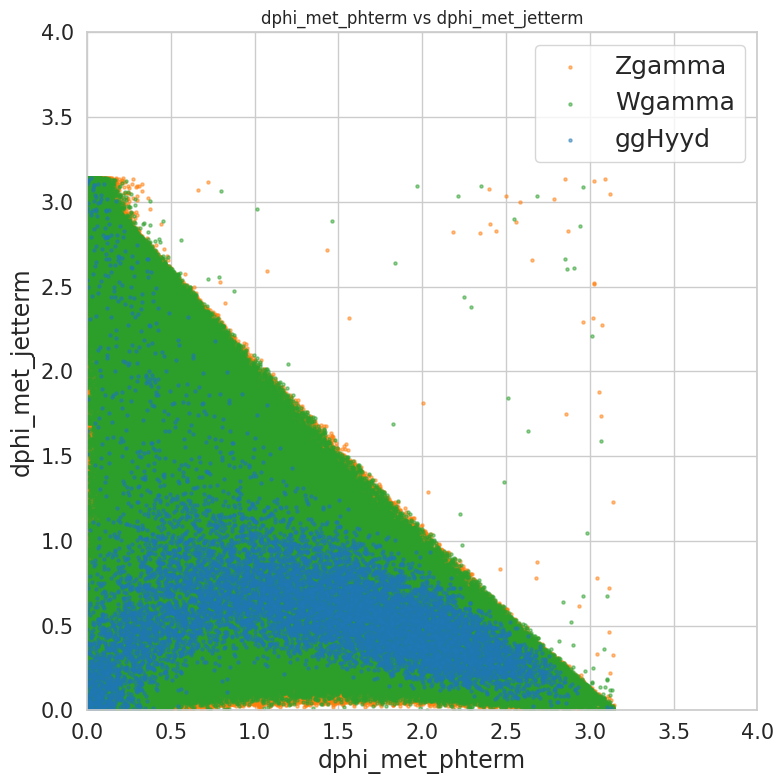

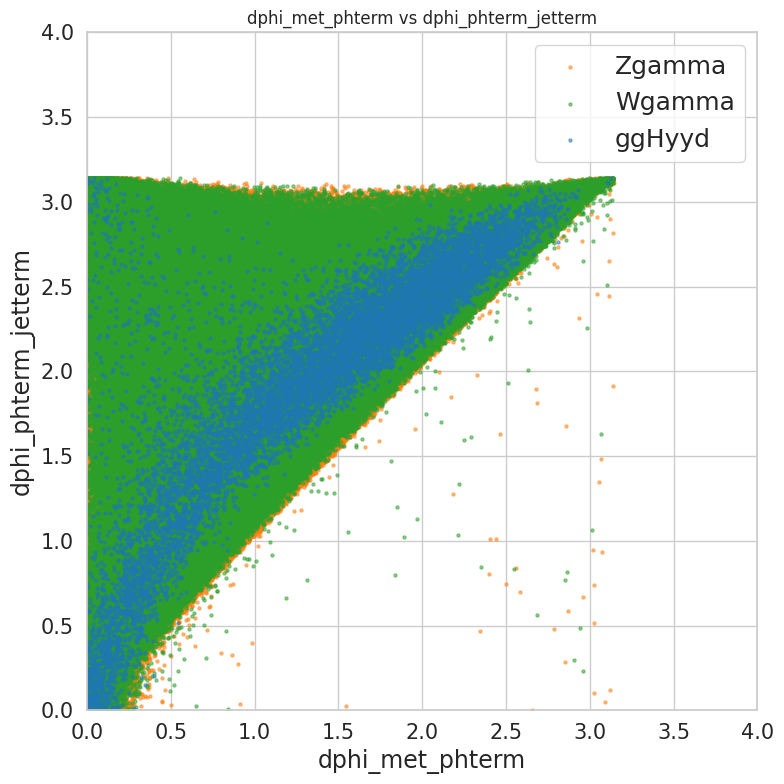

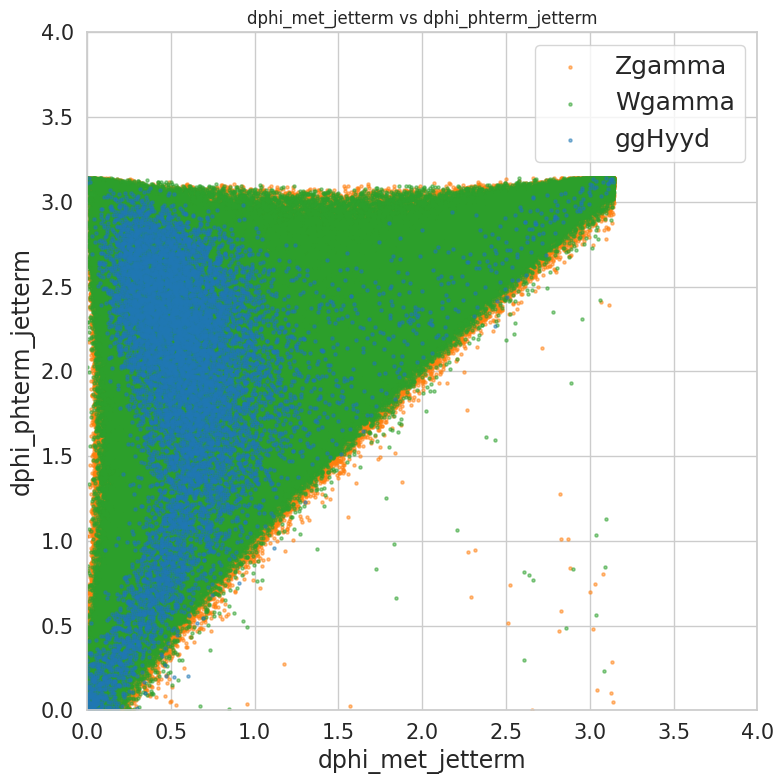

In [ ]:
pair_labels = [
    ("dphi_met_phterm", "dphi_met_jetterm"),
    ("dphi_met_phterm", "dphi_phterm_jetterm"),
    ("dphi_met_jetterm", "dphi_phterm_jetterm")
]

for xvar, yvar in pair_labels:
    plt.figure(figsize=(8, 8))
    x, y = [], []
    for i in range(len(SelectionCut)):
        process = ntuple_name[i]
        fb_tmp = SelectionCut[i]
        config_tmp = getVarDict(fb_tmp, process, var_name=None)

        x.append(config_tmp[xvar]['var'])
        y.append(config_tmp[yvar]['var'])

    plt.scatter(x[1], y[1], s=5, alpha=0.5, label=ntuple_name[1], color='tab:orange')
    plt.scatter(x[2], y[2], s=5, alpha=0.5, label=ntuple_name[2], color='tab:green')
    plt.scatter(x[0], y[0], s=5, alpha=0.5, label=ntuple_name[0], color='tab:blue') 

    plt.xlabel(xvar)
    plt.ylabel(yvar)
    plt.legend()
    plt.xlim(0, 4)  # Set x-axis limits
    plt.ylim(0, 4)  # Set y-axis limits
    plt.grid(True)
    plt.title(f"{xvar} vs {yvar}")
    plt.tight_layout()
    # plt.savefig(f"../test/2d_plots/{xvar}_vs_{yvar}_scatter_basic.png")
    # print(f'successfully saved ../test/2d_plots/{xvar}_vs_{yvar}_scatter_n-2.png')
    plt.show()

In [8]:
pair_labels = [
    ("dphi_met_phterm", "dphi_met_jetterm"),
    ("dphi_met_phterm", "dphi_phterm_jetterm"),
    ("dphi_met_jetterm", "dphi_phterm_jetterm")
]

# Color map
cmap = 'viridis'  # or 'Greys', 'plasma', etc.

# Loop over (xvar, yvar)
for xvar, yvar in pair_labels:
    for i in range(len(SelectionCut)):
        process = ntuple_name[i]
        fb_tmp = SelectionCut[i]
        config_tmp = getVarDict(fb_tmp, process, var_name=None)

        x = np.asarray(config_tmp[xvar]['var'])
        y = np.asarray(config_tmp[yvar]['var'])

        # Create log-scale 2D histogram
        plt.figure(figsize=(8, 7))
        plt.hist2d(
            x, y,
            bins=100,
            range=[[0, 4], [0, 4]],
            # norm='log',
            cmap=cmap
        )
        plt.colorbar(label='log(count)')

        plt.xlabel(xvar)
        plt.ylabel(yvar)
        plt.title(f"{process}: {xvar} vs {yvar} (Log-Z Heatmap)")
        plt.savefig(f"../test/2d_plots/{process}_{xvar}_vs_{yvar}_noLogZ_basic_80.png")
        plt.xlim(0, 4)
        plt.ylim(0, 4)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.close()